# Spiking Motif Sorting
## A first step with a mixture of motifs and dimensionality reduction

Different motifs linearly overlap in a raster plot and we treat here the cocktail party problem where results can be two fold: 
- be able to differentiate the different sources
- be able to retrieve the spiking motifs/patterns associated to the different sources

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from untitled import SM_World, plot_SM, plot_raster, make_input_and_plot_sdist, plot_embedding, plot_3d_embedding, plot_corrcoef
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap

In [25]:
class world_params:
    N_pre = 20 # number of neurons in the RP
    N_delays = 200 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 2 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

## The generative model (example with 2 motifs and a mixture of the 2)

Each kernel represents a spiking pattern that will repeat in the raster plot with more or less temporal precision. To simulate the temporal jitter associated to the different spikes of the motif, a gaussian kernel, specific to each spike (this specificity depends on *std_precision*), is used to convolve the all-or-none events (the precision is given by the standard deviation of the gaussian kernel). The mixture of the 2 kernels (here kernel #3) is given with a linear combination of the kernels with coefficients between 0 and 1. They can be normalized (sum=1) or not. 

To draw the input raster plot, we use the different kernels and a bernoulli trial that will give on raster plot for one trial. Such a raster plot (for on trial) corresponds to the time window of the kernel (prior on the detection of the motifs) and motifs can overlap only with 0 time lag. 

In [26]:
opt = world_params()
add_coef = torch.rand([opt.N_kernels])
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm()

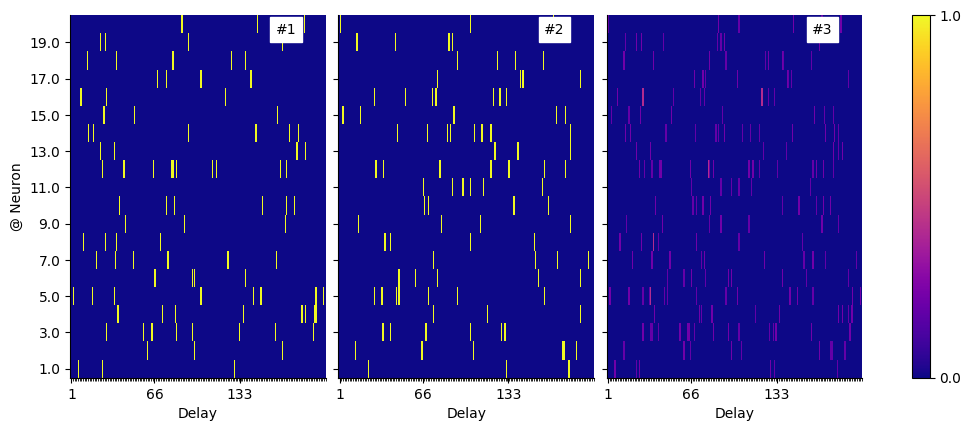

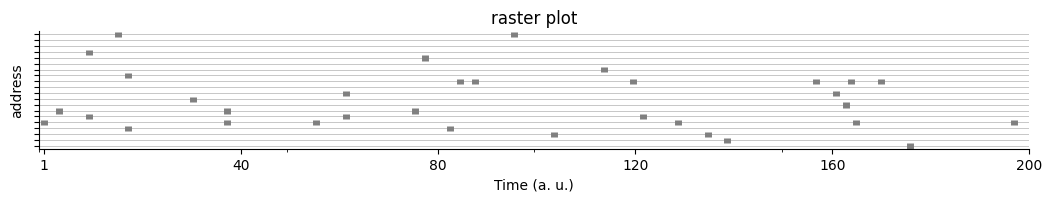

In [27]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

## Statistical test

In [9]:
input_rp, labels = world.draw_input_one_sm(N_trials=10)
print(input_rp.shape)

torch.Size([1000, 20, 51])


In [40]:
import numpy as np
ISI = np.array([])
for changes in range(500):
    add_coef = torch.rand([opt.N_kernels])
    world = SM_World(opt, add_coef = add_coef)
    input_rp, labels = world.draw_input_one_sm(N_trials=10)
    for trial in range(input_rp.shape[0]):
        for neuron in range(input_rp.shape[1]):
            timestamps = np.where(input_rp[trial,neuron,:]==1)[0]
            if len(timestamps>1):
                isi = np.diff(timestamps)
            ISI = np.hstack([ISI,isi]) if ISI.shape[0]>0 else isi

Text(0.5, 0, 'ISI')

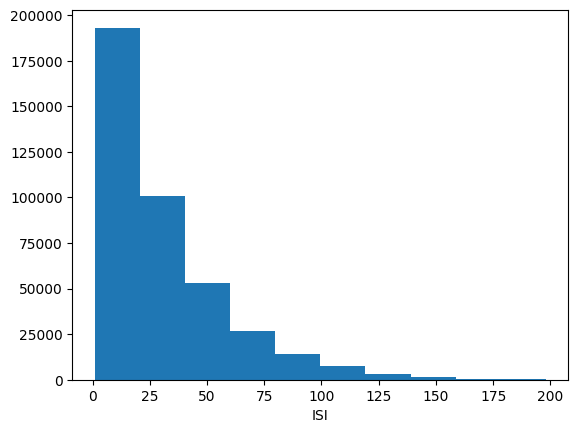

In [41]:
import matplotlib.pyplot as plt
plt.hist(ISI);
plt.xlabel('ISI')

## Format the ouput for SpikeShip and compute the dissimilarity matrix

Here, data is drawn, the total number of trials is given by $N_{trials}*N_{coef-changes}$ where $N_{coef-changes}$ represents the number of time a new set of linear combination coefficient are randomly selected. If *mixture_only* is *True*, only the last kernel (mixture of patterns) is used to make the raster plots. 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5010/5010 [00:55<00:00, 90.75it/s]


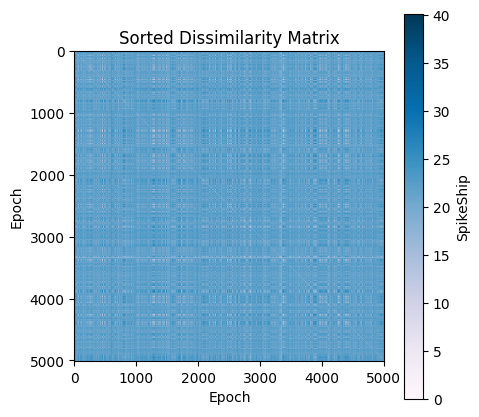

In [39]:
N_trials = 10
N_coef_changes = 500 # for each change new coefficients are drawn randomly for the mixture of the 2 motifs
normalize_coef = True
mixture_only = True
plot = True # to plot the dissimilarity matrix given by SpikeShip
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef, mixture_only=mixture_only, plot=plot)

Here we choose not to give the original patterns but just a lot of different mixtures and see how we can retrieve the different components (original patterns). The above matrix is the dissimilarity matrix computed with SpikeShip. 

## Linear decomposition

The problem is to find the components of the mixture of motifs (i.e the original kernels with which they were drawn). With this specific model, the motifs are positive values between 0 and 1 (probability of having a spike at this timestep) and they are superimposed with *add_coef* coefficients to get the mixture of motifs. 

Because of the model, linear decomposition methods applied directly on the input seem to be well suited to explain the data with a reduced number of components. The number of components should be equal to the number of original kernels ($N_{kernels}$) and $N_{kernels}-1$ if the *add_coef* coefficients are normalized to sum to 1. There are summary notebooks for [2 motifs](2023-10-03_Sum_up_2motifs.ipynb) and [3 motifs](2023-10-03_Sum_up_3motifs.ipynb) respectively. In both cases, and with normalization of the mixture coefficients, one can see that the linear composition methods used are able to explain the data with the expected number of components : $N_{kernels}-1$. Let's plot the results with the 3 motifs:

### 3 motifs' mixture results 

In [8]:
N_trials = 10
N_coef_changes = 500
normalize_coef = True
mixture_only = True
plot = False # to plot the dissimilarity matrix given by SpikeShip

class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed


opt = world_params()
add_coef = torch.rand([opt.N_kernels])
world = SM_World(opt, add_coef = add_coef)
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef, mixture_only=mixture_only, plot=plot)
input_flatten = input_rp.flatten(start_dim=1)

number_of_components=opt.N_kernels
print(f'Expected number of components {number_of_components-normalize_coef}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5010/5010 [02:12<00:00, 37.71it/s]


Expected number of components 2


#### PCA decomposition (more results can be found in [PCA notebook](2023-10-04_PCA.ipynb))

CPU times: user 1.55 s, sys: 321 ms, total: 1.87 s
Wall time: 527 ms


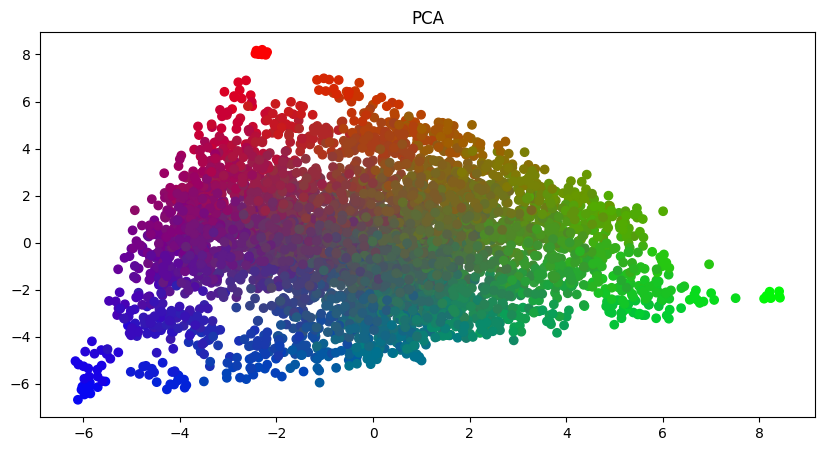

In [9]:
%%time
pca = PCA(n_components=number_of_components)
plot_embedding(pca.fit_transform(input_flatten), labels, 'PCA')

#### Non-negative matrix factorization (more results can be found in [NMF notebook](2023-10-04_NMF.ipynb))

CPU times: user 8.98 s, sys: 929 ms, total: 9.91 s
Wall time: 2.54 s


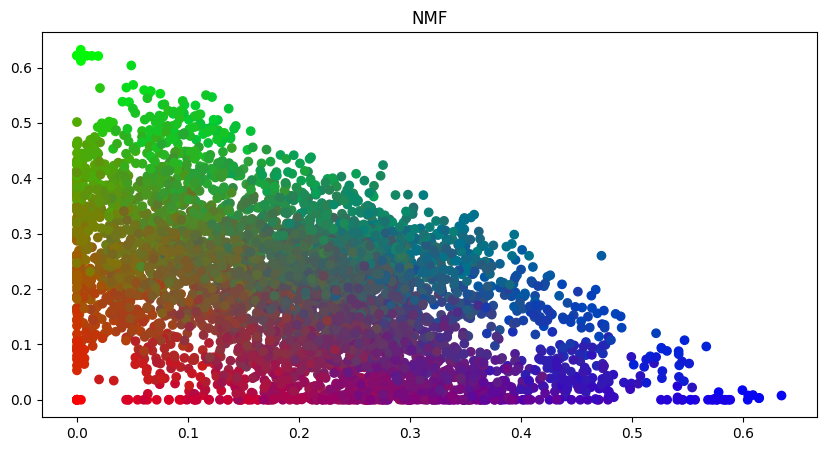

In [10]:
%%time
nmf = NMF(n_components=number_of_components) # for NMF one has to add N_kernels as the number
plot_embedding(nmf.fit_transform(input_flatten), labels, 'NMF')

As expected both methods seem to solve the separation problem, each dot color is a function of the mixture coefficients that provide the RGB values. Then, each sample is represented as a mixture of the 3 main motifs (in red, green, blue) and belong to a plan (2D). By looking at the eigenvectors of PCA or the components of NMF, we can assess if the methods can represent the different sources in the input space:

#### Eigen vectors of PCA

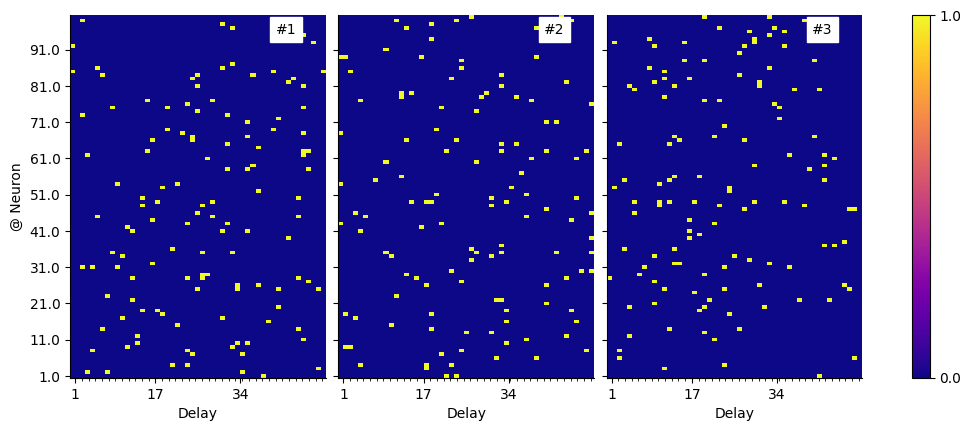

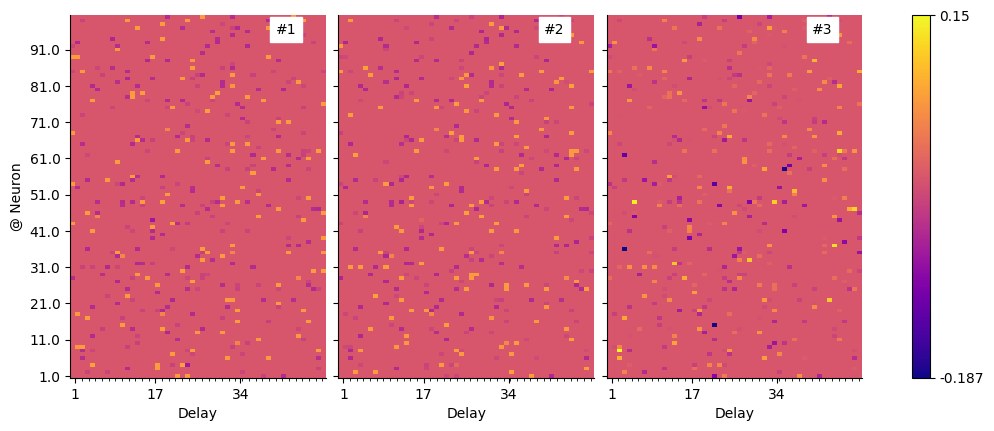

In [11]:
pca.fit(input_flatten)
estimated_kernels = pca.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

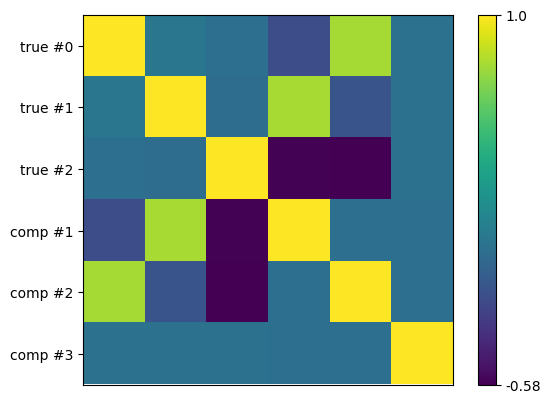

In [12]:
plot_corrcoef(world, estimated_sms)

This plot represents the correlation matrix between the eigenvectors (*comp*) and the original kernels (*true*). Because of the relationship between the coefficients due to normalization, PCA explains the data with 1 component less than the number of kernels. The first component seem to be a linear combination of the 2 last original kernels and the second component of all kernels while the last one is not correlated to any of the kernels. This method, does not solve the problem of retrieving the motifs from the combined signal. In [this notebook](2023-10-03_Sum_up_2motifs_nonorm.ipynb), coefficients are not normalized but PCA still makes a combination of the original sources to solve the problem. This comes from the way the algorithm gets the different components by first explaining the maximum of variance and then substracting the first component to find the otherones. 

#### NMF components

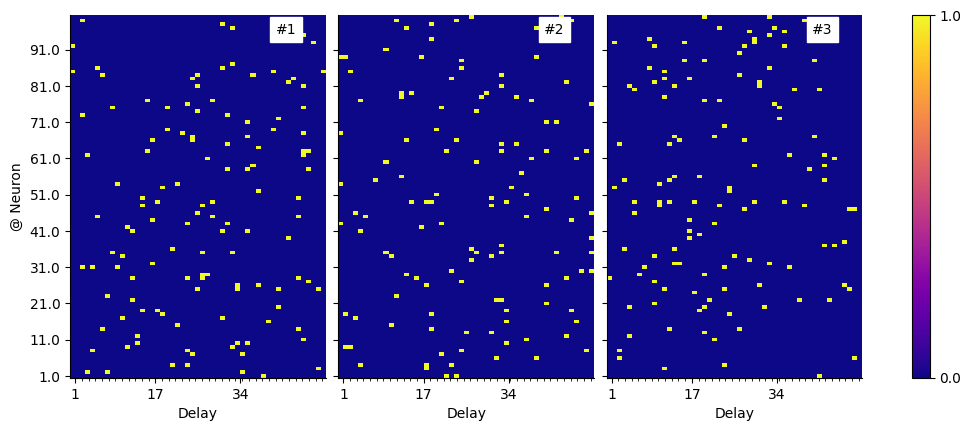

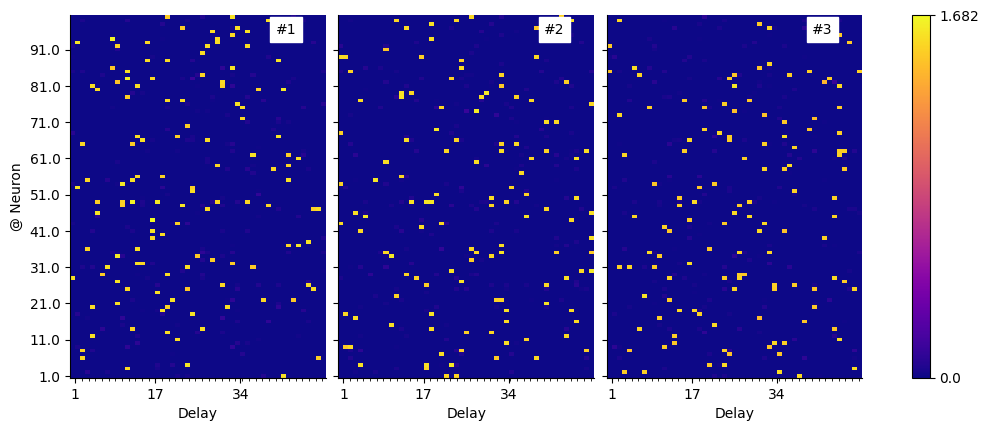

In [13]:
nmf.fit(input_flatten)
estimated_kernels = nmf.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

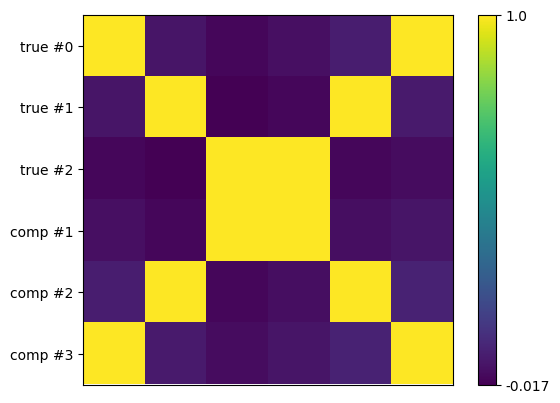

In [14]:
plot_corrcoef(world, estimated_sms)

NMF solves both problems (correlation close or equal to 1 between the true and estimated components). It comes from the assumptions that the signal has to be a linear superimposition of positive matrices with is how the generative model is working. 

### PCA on the dissimilarity matrix directly

CPU times: user 1.66 s, sys: 367 ms, total: 2.03 s
Wall time: 558 ms


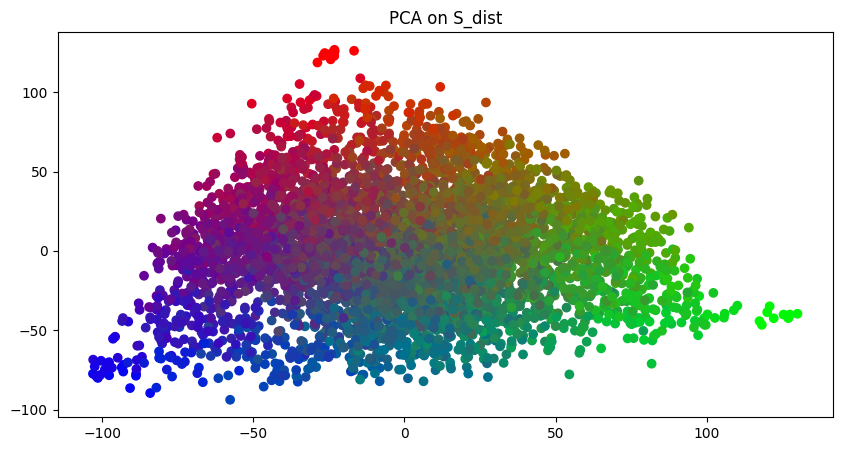

In [15]:
%%time
pca = PCA(n_components=number_of_components)
plot_embedding(pca.fit_transform(S_dist), labels, 'PCA on S_dist')

## Manifold learning using SpikeShip

Because SpikeShip is a non-Euclidian metric, results obtained using the dissimilarity matrix can be different and present a manifold learning that is not limited by linear dimensionality reduction. Let's see there what the results give with some of the nonlinear dimensionality reduction techniques: [3 motifs](2023-10-03_Sum_up_3motifs.ipynb). We give in the present notebook a summary of what was obtained. 


### Kernel PCA

To assess the efficiency of SpikeShip to extract these different motifs we used the dissimlarity matrix to do kernel PCA. SpikeShip is then the kernel used to solve the PCA decomposition but it is not able to solve the probem. Some assumptions as the fact that the kernel space should be an inner product space may not be respected with SpikeShip and make this kernel method not efficient. An intermediate level decomposition with the neural flow may achieve interesting results (to be checked). 

### Multidimensional scaling [(guide)](https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/)

MDS seems to be able to find a good manifold to represent the observations as a function of mixture coefficient. However, with this manifold learning it does not seem possible to infer components in the input space. Indeed, MDS matches the pairwise distances in the original space and the ones obtained in the reduced space with the defined number of components (that are not defined in the same space as the raster plots). 

MDS is really long to run compare to the other algorithms.

The method was also tried on the input directly and no qualitative difference was observed. 

### Isomap

Pretty similar comments as for MDS. This technique is not working locally though (with a reduced number of nearest neighbors for the search). Qualitatively better with the maximum amount of NN equal to the number of observation.

### Spectral embedding with laplacian eigenmaps

This method does not solves the problem using the precomputed dissmilarity matrix obtained from SpikeShip. However, when using the 'nearest_neighbors' on this precomputed values some manifold appears that can solve the source detection problem. It does not seem to be very accurate though and this seems to show that SpikeShip cannot solve the linear combination problem because the output of the metric would not be a linear combination of the metric between the different patterns. When using the input directly and the radial basis function as affinity, then laplacian eigenmaps solves the problem (see [2 motifs](2023-10-03_Sum_up_2motifs.ipynb)). 

### t-SNE

t-SNE does not seem to solve completely the problem even with a different choice of hyperparameters and when trying to apply it on the input and not on the dissimilarity matrix. 

## Conclusion

From this notebook, we observe that linear decomposition methods are able to efficiently solve the source separation problem. Because the signal is a linear combination of the input patterns, these techniques may be more appropriated. And the NMF method is able to estimate the different patterns combined to produce the mixture efficiently unlike PCA for which the components are only slightly correlated with the true patterns. Similar results are observed even with some temporal jitter that changes the precision of the motifs. NMF is able to efficiently retrieve the different kernels with the variability in the precision of the motifs (see [3 motifs with jitter](2023-10-03_Sum_up_3motifs.ipynb)). 

Surprisingly, kernel PCA with SpikeShip as the kernel does not obtain good results. Other manifold learning methods can seperate sources with maybe less efficiency than the linear methods and cannot decompose the signal into different sources because they mainly map the pairwise distances in a lower dimensional space. The spectral embedding technique did not work when using SpikeShip as the metric but could describe the inputs as a combinaison of different sources with the radial basis function as 'affinity'. This may show that, as such, SpikeShip may not be the appropriate metric to describe the raster plot as a superimposition of different spiking motifs. Also, the normalization of the number of spikes between 2 neurons and 2 epochs can trigger unwanted behavior for this problem. Using the neural flows can be a better representation to extract some motifs. 

The generative model can also be modified to make a more bio-plausible generation of the events and see if the successful methods still achieve good performances. 

## Next steps

Our problem can be formulated as such:
Let's set X the raster plot we want to describe. We want to explain much of the variance of the signal thanks to a superimposition of spiking motifs that we call $M_i$. Then: 
$$X=\sum_i{w_i M_i} + \text{noise}$$
We want to infer $\hat{X}=\sum_i{a_i D_i} = A \cdot D$ such that $d_s(X,\hat{X})$ (the SpikeShip distance, another metric has to be defined if SpikeShip is not appropriated for this problem, to be checked) is as small as possible. 
- $A$ respresents the activation of the different parts of the dictionnary of spiking motifs learnt by the model. It may be binary values because of the way SpikeShip is defined $\rightarrow$ normalization of the number of spikes between 2 epochs and 2 neurons. But this has to be better defined. 
- $D$ represents the dictionnary of spiking motifs to describe the spike train. The different $D_i$ should not be redundant and have as much spikes as possible. 

### Check if SpikeShip is the good metric for this problem

A first step for the formal definition of the problem is to assess if SpikeShip can be used efficiently for this problem.
- is it possible to find a function/kernel $k()$ such that (or what would be the relationship?):
$$d_s(X, w_1 D_1 + w_2 D_2) = k(w'_1 d_s(X, D_1) + w'_2 d_s(X, D_2))$$
    - using this kernel with kernel PCA may solve the problem efficiently
    - with the SpikeShip format, Ds can be concatenated to obtain $\hat{X}$ and the weights may not be useful (can be a limitation for the linear combination problem)
    - with SpikeShip, even if the spikes are prefectly recovered by superimposing the proper $Ds$, meaning that $d_s(X,\hat{X}) = 0$, then $\sum_{k=active Ds}d_s(X,D_k) > 0$. This can be corrected by a function applied on the neural flow (exponential decay mentioned during previous meetings) that assess the local accuracy of the motifs? Has to be checked    

### Extract the neural flows and see if patterns can be extracted from these

Precise temporal motifs will lead to neural flow close to 0. Finding the smallest value of SpikeShip and finding a trade-off between a threshold for the neural flow values and a minimum number of elements in the motif can lead to motifs extraction. 

### Change the model to have more realistic spike trains